# Machine Learning Homework 2

## Senad Kurtiši

In [5]:
%load_ext autoreload
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%autoreload 2
from utils import *

import logistic_regression
import softmax
import GDA
import GNB

# Dataset
## Description 
Dataset consists out of 178 samples divided into three classes. The dataset is slightly unbalanced so during the train-test split we stratify the test so we would maintain the class-to-class ratio. We use 20% of the dataset for the test set. Test set is used
for final evaluation of the models.

In [7]:
dataset_path = 'multiclass_data.csv'
df = pd.read_csv(dataset_path, header=None)

dataset = df.values
features = dataset[:, :-1].copy()
output = dataset[:, -1].copy()

test_pct = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(features, \
                                                    output, \
                                                    test_size=test_pct, \
                                                    stratify=output,
                                                    random_state=1234)

Y_train = np.expand_dims(Y_train, -1)
Y_test = np.expand_dims(Y_test, -1)

n_features = X_train.shape[-1] + 1

In [8]:
# Will be used for final evaluation on the test set
X_train_ext, X_test_ext = external_standardization(X_train, X_test)

# 1. Logistic Regression
## Theory
Logistic Regression is model used for binary classification. The output of this model is probability that the input example belongs to a certain class (ex: positive/negative distinction). This model uses sigmoid as the activatiob function

Sigmoid: $$ g(z) = \frac{1} {1+exp(-z)} $$

Output: $$ P(y=1|X) = \frac{1} {1+exp(-{W^{T} X})} $$

## One-vs-All
Because we have three classes we can't use Logistic Regression as is. Along with that we train three different Logistic Regression models one for each class. Then during evaluation on the validation/test set we get the probability P(y={0,1,2}|x) from all three models and choose the one which is most sure that the sample x belongs to it's class. The models are trained using **batch gradient descent**.

We need to adapt the target output for each of the classifiers.
Ex: for classifier zero we label each example from class zero as 1, and samples from classes one and two as 0. We perform similar process for the remaining two models.

In [9]:
# Prepare output labels for training Logistic Regression models
target_zero_train, target_one_train, target_two_train = \
                transform_to_binary_output(Y_train)
target_zero_test, target_one_test, target_two_test =\
                transform_to_binary_output(Y_test)

### K-fold cross validation for the learning rate hyperparameter

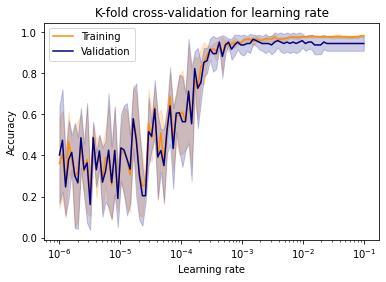

Max val. acc: 0.9650246305418719
Best lr: 0.0015199110829529332


In [148]:
epochs = 300
k = 5   # number of folds

# Learning rates to be tested
l_rates = np.logspace(-6, -1, 100)

# Classifier for class 0
classifier_zero = logistic_regression.BinaryClassifier(n_features, 0)
# Trainer for the classifier 0
trainer_zero = logistic_regression.TrainerLogistic(classifier_zero, epochs)

# Classifier for class 1
classifier_one = logistic_regression.BinaryClassifier(n_features, 1)
# Trainer for the classifier 1
trainer_one = logistic_regression.TrainerLogistic(classifier_one, epochs)

# Classifier for class 2
classifier_two = logistic_regression.BinaryClassifier(n_features, 2)
# Trainer for the classifier 2
trainer_two = logistic_regression.TrainerLogistic(classifier_two, epochs)

# List of all Trainers
trainers = [trainer_zero, trainer_one, trainer_two]
# Perform the K-fold cross validation for learning rate
history = logistic_regression.k_fold_CV(trainers, X_train, \
                                        [target_zero_train, target_one_train,\
                                        target_two_train], \
                                        Y_train, k, l_rates)

# Show the result of K-fold cross validation
show_plot(l_rates, history, \
          title="K-fold cross-validation for learning rate", \
          xlabel="Learning rate", ylabel="Accuracy", scale="log")

# Get the maximum validation accuracy
max_acc = max(history['val_mean'])
print("Max val. acc:", max_acc)
# Get the according learning rate
best_lr= l_rates[np.argmax(history['val_mean']==max_acc)]
print("Best lr:", best_lr)

### Train the Logistic Regression models

In [149]:
epochs = 300
# Three distinct Logistic Regression models
classifier_zero = logistic_regression.BinaryClassifier(n_features, 0)
classifier_one = logistic_regression.BinaryClassifier(n_features, 1)
classifier_two = logistic_regression.BinaryClassifier(n_features, 2)

# Adequate trainers for the models above
trainer_zero = logistic_regression.TrainerLogistic(classifier_zero, epochs)
trainer_one = logistic_regression.TrainerLogistic(classifier_one, epochs)
trainer_two = logistic_regression.TrainerLogistic(classifier_two, epochs)

In [150]:
# Train all three classifiers
_, _ = trainer_zero.train([X_train_ext, target_zero_train], lr=best_lr)
_, _ = trainer_one.train([X_train_ext, target_one_train], lr=best_lr)
_, _ = trainer_two.train([X_train_ext, target_two_train], lr=best_lr)

### Evaluating on the test set

In [151]:
y_hat_zero = classifier_zero.predict(X_test_ext)
y_hat_one = classifier_one.predict(X_test_ext)
y_hat_two = classifier_two.predict(X_test_ext)

# Make the final decision
y_hat = np.argmax([y_hat_zero, y_hat_one, y_hat_two], axis=0)

# Calculate the test set accuracy
acc = (y_hat==Y_test).mean()*100
print(f"One-vs-All test acc: {acc:.2f} %", )

One-vs-All test acc: 100.00 %


On the graph bellow we can see that for different learning rates we get different results. The main difference is the speed of convergence. The higher the learning rate, the higher the convergence is. But, we must carefully choose this hyperparameter for multiple reasons:
* Learning rate which is too large might lead to overshooting the global minima, and sometimes lead to divergent oscilations
* If we choose learning rate which is too small, the convergence would be too small

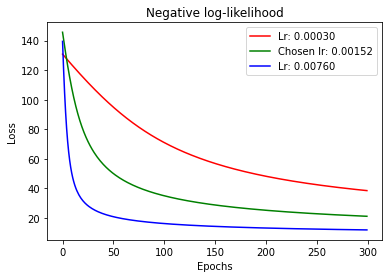

In [168]:
epochs = 300
l_rates = [best_lr/5, best_lr, best_lr*5]

# Logistic Regression model for Class 0
classifier_zero = logistic_regression.BinaryClassifier(n_features, 0)
# Trainer for the class 0 logistic regression
trainer_zero = logistic_regression.TrainerLogistic(classifier_zero, epochs)

plt.figure()
color = ['r','g','b']
for i, lr in enumerate(l_rates):
    # Re-initialize the classifier weights
    classifier_zero.init_weights()
    # Train the model with current learning rate
    _, train_loss = trainer_zero.train([X_train_ext, \
                                    target_zero_train], \
                                    lr=lr, calc_loss=True)
    if i==1:
        label = f"Chosen lr: {lr:.5f}"
    else:
        label = f"Lr: {lr:.5f}"
    
    # Show the loss for current learning rate
    plt.plot(-np.array(train_loss), c=color[i], label=label)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Negative log-likelihood")
plt.legend()
plt.show()

We see that for higher learning rates we get faster convergence.

# 2. Softmax

## Theory 
Softmax classifier is generalized version of the Logistic Regression for N classes. The output of the softmax model are the probabilities that input sample x belongs to each of those classes. The final decision is made in such manner that the model says that x belongs to the class for which the probability is the highest. 

## Training
Training of this model is performed using **stochastic mini-batch gradient descent**.

### Softmax: K-fold cross-validation for learning rate

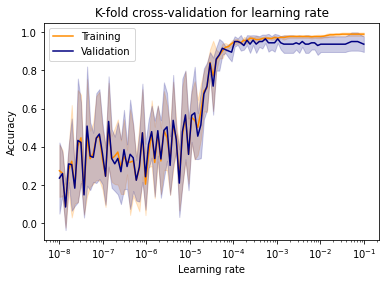

Max val. acc: 0.9650246305418719
Best lr: 0.0010476157527896642


In [57]:
class_num = 3
epochs = 300
k = 5   # number of folds

# Learning rates to be tested
l_rates = np.logspace(-8, -1, 100)

# Softmax model
softmax_model = softmax.Softmax(class_num, n_features)
# Trainer for the softmax model
trainer = softmax.TrainerSoftmax(softmax_model, epochs)

# Perform K-fold cross validation for learning rate
history = softmax.k_fold_CV_lr(trainer, X_train, \
                               Y_train, k, \
                               l_rates=l_rates)

# Show result of the K-fold cross validation
show_plot(l_rates, history, \
          title="K-fold cross-validation for learning rate", \
          xlabel="Learning rate", ylabel="Accuracy", scale="log")

# Get the maximum validation accuracy
max_acc = max(history['val_mean'])
print("Max val. acc:", max_acc)
# Get the according learning rate
best_lr = l_rates[np.where(history['val_mean']==max_acc)][-1]
print("Best lr:", best_lr)

### Softmax: K-fold cross-validation for mini-batch size

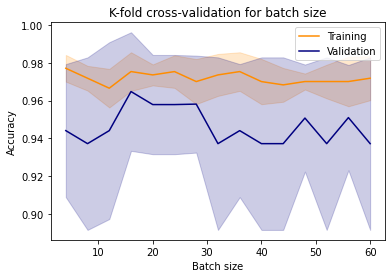

Max val. acc: 0.9647783251231526
Best bs: 16


In [164]:
k = 5  # Number of folds

# All batch sizes tested 
b_sizes = np.arange(4, 64, 4)

# Softmax model
softmax_model = softmax.Softmax(class_num, n_features)
# Trainer for the softmax model
trainer = softmax.TrainerSoftmax(softmax_model, epochs)

# Perform K-fold cross validation for batch size
history = softmax.k_fold_CV_bs(trainer, X_train, \
                               Y_train, k, lr=lr,\
                               b_sizes=b_sizes)

# Show result of K-fold cross validation
show_plot(b_sizes, history, \
          title="K-fold cross-validation for batch size", \
          xlabel="Batch size", ylabel="Accuracy", scale="linear")

# Get maximum validation accuracy 
max_acc = max(history['val_mean'])
print("Max val. acc:", max_acc)
# Get according batch size
best_bs = b_sizes[np.where(history['val_mean']==max_acc)][-1]
print("Best bs:", best_bs)

### Softmax: Mini-batch size
How does batch size influence the training process?

If we choose smaller mini-batch size then we get more oscilations on the loss graph during training. The reason behind this is the fact that after every iteration optimal point in feature space changes and adapts to current mini-batch being processed. For smaller mini-batch sizes we have more iterations per epoch and therefore more "different optimal points". On the other hand batch gradient descent doesn't have such fluctuations in the training process because entire dataset is being processed at once.

For this dataset it isn't a big deal but for much larger datasets, it can lead to computational overhead.
By using mini batches we can relaxate the computation requirements of the training process but still use the benefits of modern processors related to parallel computations which are utilized by performing vectorized operations i.e. using mini-batches(matrices) instead of processing one sample at a time.

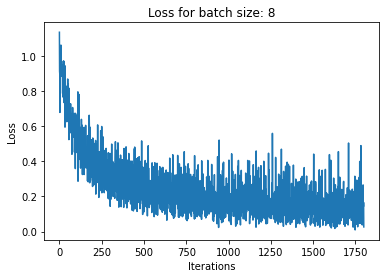

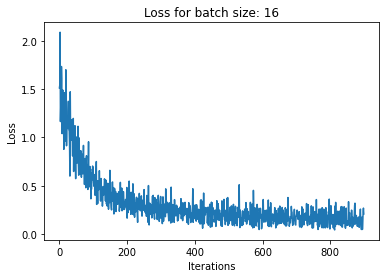

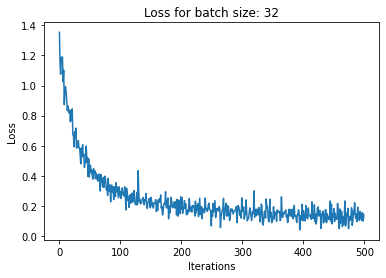

In [64]:
lr = best_lr

epochs = 100
for bs in [8, 16, 32]:
    # Softmax model
    softmax_model = softmax.Softmax(class_num, n_features)
    # Trainer for the softmax model
    trainer = softmax.TrainerSoftmax(softmax_model, epochs)
    
    # Train the model and make sure the loss is calculated
    train_loss = trainer.train(X_train_ext, Y_train, \
                               lr, bs, calc_loss=True)
    
    # Show the loss for current batch size
    plt.figure()
    plt.plot(-np.array(train_loss))
    plt.title(f"Loss for batch size: {bs}")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

## Softmax: Evaluation on the test set
We can see that the Softmax classifier achieves excellent results on the test set

In [65]:
softmax_model = softmax.Softmax(class_num, n_features)
# A trainer for the Softmax model
trainer = softmax.TrainerSoftmax(softmax_model, epochs)
# Train the model
_ = trainer.train(X_train_ext, Y_train, best_lr, best_bs)

# Get the prediction for the test set
y_hat = softmax_model.predict(X_test_ext)
y_hat = np.expand_dims(np.argmax(y_hat, axis=1), -1)

# Calculate prediction accuracy
acc = (y_hat==Y_test).mean()*100
print(f"Test acc: {acc:.2f} %")

Test acc: 100.00 %


# 3. Gaussian Discriminant Analysis

## Theory
Gaussian Discriminative Analysis or GDA is a generative method which unlike Logistic Regression for example first tries to learn the distribution of features for each class $p(X | y)$. Then using the learned parameters of feature distributions for each class it uses those parameters to finally evaluate $p(y|X)$, where in this case $X$ represents features of test samples, by using:

$$ p(y=1|X) = \frac {p(X|y=1) p(y=1) } {p(X)} $$

The expression above stands for cases in which we have two classes. 

This method is called *Gaussian* because it assumes the features have normal distribution: $ X|y$ ~ $ N(\mu(y), \Sigma(y)) $. 
If we wish to learn the parameters of these distributions we do that by equalizing the gradient of log-likelihood to *0* and analytically solving each equation in order to calculate parameters of feature distribution for each class: $$ \mu_{i}, \Sigma_{i}; i=\overline{1..K} $$ where **K** is the number of classes.

In [109]:
distrib_zero  = GDA.Distribution(X_train_ext[:, 1:], Y_train, 0, n_features-1)
distrib_one  = GDA.Distribution(X_train_ext[:, 1:], Y_train, 1, n_features-1)
distrib_two  = GDA.Distribution(X_train_ext[:, 1:], Y_train, 2, n_features-1)

## GDA: Evaluating on the test set

For each sample **X*** in the test set we calculate the probability that features of sample X* come from distributions we have previously learned i.e.:

$$ 
p(X^* | y_k) = \frac{exp(-\frac{1}{2} (X^* - \mu_k)^T \Sigma_k^{-1} (X^* - \mu_k))}{\sqrt{(2 \pi)^n |\Sigma|}} 
$$

We use this information to get the probability that X* belongs to all possible classes:
$$ 
p(y = y_k|X) \propto p(X|y_k) p(y_k)
$$

We make final decision based on which probability is the highest:
$$
\hat{y} = {\arg\max}_{y} p(y\mid x) = {\arg\max}_{y} p(x\mid y)p(y)
$$

Bellow we can see evaluation process on the test set.

In [110]:
correct = 0

for test_feat, test_out in zip(X_test_ext[:,1:], Y_test):
    p_zero = distrib_zero(test_feat) * distrib_zero.p
    p_one = distrib_one(test_feat) * distrib_one.p
    p_two = distrib_two(test_feat) * distrib_two.p

    y_hat = np.argmax([p_zero, p_one, p_two])
    correct += int(y_hat==test_out)

print(f"GDA test acc: {correct/len(Y_test)*100:.2f} %")

GDA test acc: 100.00 %


## GDA: Comparing the model to built-in QDA model


In [112]:
# Built-in Quadratic Discriminative model
qda = QuadraticDiscriminantAnalysis(store_covariance=True).fit(X_train_ext[:, 1:], Y_train.flatten())
# Get the prediction
y_test_hat = qda.predict(X_test_ext[:, 1:])

acc = (y_test_hat==Y_test.flatten()).mean()*100
print(f"Sklearn test acc: {acc:.2f}")

Sklearn test acc: 100.00


We see that performances on the test set match!

# 4. Gaussian Naive Bayes

## Theory
Unlike GDA model Naive Bayes doesn't assume the distribution of input features. For this dataset though we see that the values for features are real number so we use the **Gaussian Naive Bayes (GNB)**. One more important difference is that GNB assumes that distinct features are not correlated in any way for a fixed value of the output, in this case the class of the sample. 

The latter difference influences the model structure a lot, we now model distribution for every feature of every class. In this case a total of 12 Gaussian distributions. (3 classes * 4 features)

$$ p(y_i | x^*) \propto p(y_i)\ \prod_{j=1}^{n} p(x_j^* | y_i) $$

In [130]:
distrib_zero  = GNB.Distribution(X_train_ext[:, 1:], Y_train, 0)
distrib_one  = GNB.Distribution(X_train_ext[:, 1:], Y_train, 1)
distrib_two  = GNB.Distribution(X_train_ext[:, 1:], Y_train, 2)

## GNB: Evaluating on the test set

For each feature $x_i$ of each sample **X*** in the test set we calculate the probability that feature $x_i$ comes from distribution we have previously learned i.e.
$ p(x_i|y_k) $

Considering that main and only assumption of GNB model is that features are not correlated for fixed **y**, we get:
$$ p(X|y_k) = \prod_{i=1}^{n} p(x_i^* | y_k) $$

For each class we calculate the probability that sample **X*** belongs to that class, and make a decision by choosing the class which resulted in highest probability.

$$ p(y_i | x^*) \propto p(y_i)\ \prod_{j=1}^{n} p(x_j^* | y_i) $$

In [131]:
correct = 0
y_hat_test = []

for test_feat, test_out in zip(X_test_ext[:, 1:], Y_test):
    p_zero = distrib_zero(test_feat) * distrib_zero.p
    p_one = distrib_one(test_feat) * distrib_one.p
    p_two = distrib_two(test_feat) * distrib_two.p

    y_hat = np.argmax([p_zero, p_one, p_two])
    correct += int(y_hat==test_out)
    y_hat_test.append(y_hat)

print(f"GNB test acc: {correct/len(Y_test)*100:.2f} %")

GNB test acc: 97.22 %


## GNB: Comparing to the built-in GNB model

In [132]:
# Built-in GNB model
gnb = GaussianNB().fit(X_train_ext[:, 1:], Y_train)
# Get the prediction on the test set
y_test_hat = gnb.predict(X_test_ext[:, 1:])

acc = (y_test_hat==Y_test.flatten()).mean()*100
print(f"Sklearn test acc: {acc:.2f}")

Sklearn test acc: 97.22


Here we witness again that we get the same results when using the built-in model.

### GNB: Confusion matrix

We can see that GNB model doesn't classify each sample from test set correctly. Let's take a closer look.



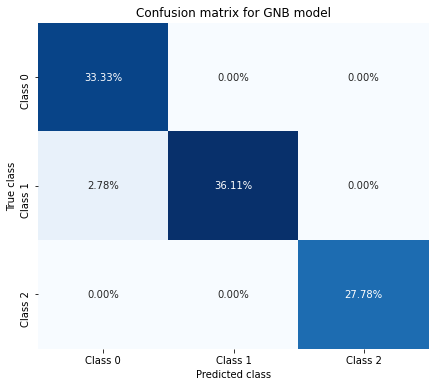

In [138]:
labels = [0, 1, 2]
classes = ["Class 0", "Class 1", "Class 2"]

# Get the confusion matrix
c_matrix = confusion_matrix(y_true=Y_test, \
                            y_pred=np.array(y_hat_test), \
                            labels=labels, )

# Show the confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues', cbar=False, \
            xticklabels=classes, \
            yticklabels=classes)

plt.title("Confusion matrix for GNB model")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

We see that in 2.78% cases GNB model fails to properly classify the the Class 1 (it classifies those samples as Class 0).

If we look just at the percentage 2.78 % seems like a really big error, but it's only one sample. We get 2.78% error because test set consists out of 36 samples which actually 20% of the entire dataset.

# Comparing models and conclusion

Bellow we can see the table which contains accuracy on the test set for current split for every model.

| Model | Test accuracy |
|:-----:|:-------------:|
| One-vs-All | 100.00%|
| Softmax | 100.00% |
| GDA | 100.00% |
| GNB | 97.72% |

For different splits results vary, but most of the time GDA model outperforms the GNB. The reason behind this may be the fact that features are correlated in some way. 
Most of the time One-vs-All and Softmax outperform the other two models, but on the other side, GDA and GNB are trained faster than these two models in general. The previous claim does not fully stand in this particular case because the dataset is small but for the much larger datasets iterating through a large dataset in order to perform forward and backward pass can take quite of time.